In [1]:
import numpy as np
import cv2
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from keras.layers import Dropout,Flatten
from keras.layers.convolutional import Conv2D,MaxPooling2D
import pickle
import tensorflow as tf
from tqdm import tqdm
from imblearn.under_sampling import RandomUnderSampler
import pandas as pd
import seaborn as sns

## import drive and GPU

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [4]:
train_path ="/content/drive/MyDrive/ML/Preprocess_Results/Train"
test_path ="/content/drive/MyDrive/ML/Preprocess_Results/Test"

image_size=(128,128,3)

In [5]:
category_list = os.listdir(train_path)
category_list

['DME', 'Normal']

In [6]:
number_of_classes= len(category_list)

# get the images

In [7]:
def get_image_list(path, categories):
    images=[]
    class_num=[]
    for cat in (categories):
        img_list = os.listdir(path +'/'+cat)
        for img in tqdm(img_list):
            im = cv2.imread(path +'/'+cat+"/"+img)
            im = cv2.resize(im, (image_size[0], image_size[1]))
            images.append(im)
            class_num.append(categories.index(cat))
    return images, class_num

In [8]:
x_train, y_train = get_image_list(train_path, ['Normal',"DME"])
x_val, y_val = get_image_list(test_path, ['Normal',"DME"])

100%|██████████| 42/42 [00:00<00:00, 245.22it/s]


In [9]:
print(len(x_train), len(y_train), len(x_val), len(y_val))

2229 2229 84 84


# Get test set 
- current test set used as validation set

In [10]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.3, random_state=42)

In [11]:
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)
x_val = np.array(x_val)
y_val = np.array(y_val)

In [12]:
print(x_train.shape)
print(x_test.shape)
print(x_val.shape)

(1560, 128, 128, 3)
(669, 128, 128, 3)
(84, 128, 128, 3)


In [13]:
numofSamples=[]
for x in range(0,number_of_classes):
    numofSamples.append(len(np.where(y_train==x)[0]))

In [14]:
print(numofSamples, min(numofSamples))

[709, 851] 709


In [15]:
CATEGORIES = ['Normal',"DME"]

# Convert images to grayscale

In [16]:
def convert_to_gray(img):
    img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    return img

In [17]:
x_train = np.array(list(map(convert_to_gray,x_train)))
x_test = np.array(list(map(convert_to_gray,x_test)))
x_validation = np.array(list(map(convert_to_gray,x_val)))
print(x_train.shape, x_test.shape,x_validation.shape)

(1560, 128, 128) (669, 128, 128) (84, 128, 128)


# Model definition

In [18]:
y_train = to_categorical(y_train,number_of_classes)
y_test = to_categorical(y_test,number_of_classes)
y_validation = to_categorical(y_val,number_of_classes)

In [19]:
def model():
    filters=60
    sizeoffilter1 = (5,5)
    sizeoffilter2 = (4,4)
    sizeoffilter3 = (3,3)
    sizeofpool = (2,2)
   

    model = Sequential();
    model.add((Conv2D(filters,sizeoffilter1,input_shape=(image_size[0],image_size[1],1),activation="relu")))

    model.add((Conv2D(filters,sizeoffilter1,activation="relu")))
    model.add((Conv2D(filters//2,sizeoffilter2,activation="relu")))
    model.add((Conv2D(filters//2,sizeoffilter2,activation="relu")))
    model.add(MaxPooling2D(pool_size=sizeofpool))
    model.add(Dropout(0.2))

    model.add((Conv2D(filters,sizeoffilter1,activation="relu")))
    model.add((Conv2D(filters//2,sizeoffilter2,activation="relu")))
    model.add((Conv2D(filters//2,sizeoffilter2,activation="relu")))
    model.add(MaxPooling2D(pool_size=sizeofpool))
    model.add(Dropout(0.2))

    model.add((Conv2D(filters,sizeoffilter2,activation="relu")))
    model.add(MaxPooling2D(pool_size=sizeofpool))
    model.add((Conv2D(filters//2,sizeoffilter3,activation="relu")))
    model.add((Conv2D(filters//2,sizeoffilter3,activation="relu")))
    model.add(MaxPooling2D(pool_size=sizeofpool))
    model.add(Dropout(0.2))

    model.add(Flatten())
    model.add(Dense(5000,activation="relu"))
    model.add(Dropout(0.2))
    model.add(Dense(number_of_classes,activation="softmax"))

    model.compile(Adam(lr=0.001),loss="categorical_crossentropy",metrics=['accuracy'])

    return model
  
model=model()

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 124, 124, 60)      1560      
                                                                 
 conv2d_1 (Conv2D)           (None, 120, 120, 60)      90060     
                                                                 
 conv2d_2 (Conv2D)           (None, 117, 117, 30)      28830     
                                                                 
 conv2d_3 (Conv2D)           (None, 114, 114, 30)      14430     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 57, 57, 30)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 57, 57, 30)        0         
                                                        

In [21]:
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [22]:
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
checkpoint = ModelCheckpoint(filepath='best_weights.hdf5', save_best_only=True, save_weights_only=True)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=2, mode='max')

In [23]:
history = model.fit(x_train,y_train,epochs=30 ,validation_data =(x_test,y_test) ,batch_size=16,
                    shuffle=True,
                    max_queue_size=20,
                    use_multiprocessing=True,
                    workers=1,
                    callbacks=[checkpoint, lr_reduce])

Epoch 1/30
98/98 [==============================] - 15s 79ms/step - loss: 0.7816 - accuracy: 0.5256 - val_loss: 0.6853 - val_accuracy: 0.5217 - lr: 0.0010
Epoch 2/30
98/98 [==============================] - 6s 63ms/step - loss: 0.6332 - accuracy: 0.6346 - val_loss: 0.6296 - val_accuracy: 0.6069 - lr: 0.0010
Epoch 3/30
97/98 [============================>.] - ETA: 0s - loss: 0.6350 - accuracy: 0.6282
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
98/98 [==============================] - 6s 63ms/step - loss: 0.6342 - accuracy: 0.6295 - val_loss: 0.6224 - val_accuracy: 0.6667 - lr: 0.0010
Epoch 4/30
98/98 [==============================] - 6s 64ms/step - loss: 0.5628 - accuracy: 0.7077 - val_loss: 0.5362 - val_accuracy: 0.7399 - lr: 3.0000e-04
Epoch 5/30
97/98 [============================>.] - ETA: 0s - loss: 0.5443 - accuracy: 0.7197
Epoch 5: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
98/98 [==============================] - 6s 65ms/s

In [24]:
print("model training is complete")

model training is complete


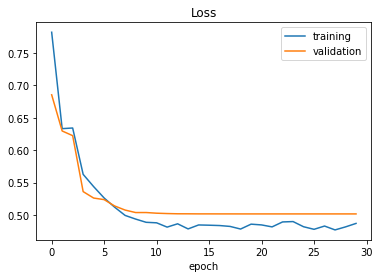

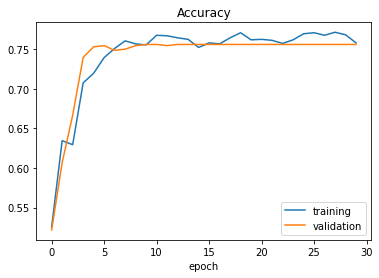

In [25]:
plt.figure(1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training','validation'])
plt.title('Loss')
plt.xlabel('epoch')
plt.figure(2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training','validation'])
plt.title('Accuracy')
plt.xlabel('epoch')
plt.show()

In [26]:
score = model.evaluate(x_validation,y_validation,verbose=0)
print('Test Score = ',score[0])
print('Test Accuracy = ',score[1])

Test Score =  0.3953252136707306
Test Accuracy =  0.8095238208770752


In [27]:
y_pred = model.predict(x_validation)
y_pred = tf.argmax(y_pred, axis = 1)
y_validation = tf.argmax(y_validation, axis = 1)

Text(0.5, 1.0, 'Confusion Matrix')

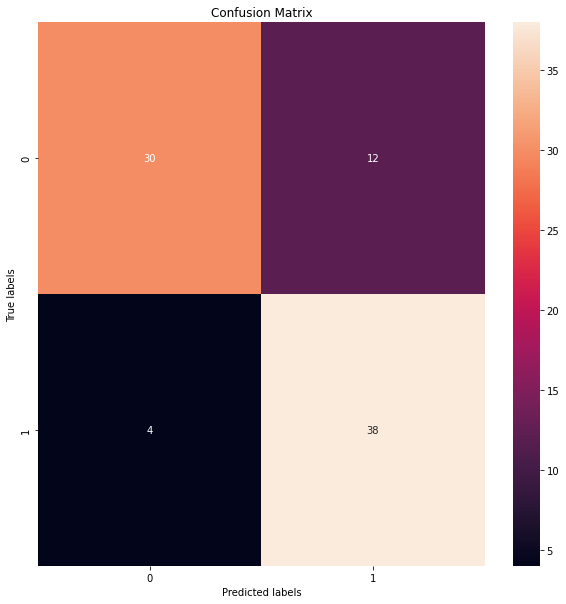

In [30]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt     
import seaborn as sns

cm = confusion_matrix(y_validation, y_pred)
plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt='g')

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')

In [29]:
model.save('model2_50epochs.hd5')